In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import os
import sys
import pickle

from utilities3 import *
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer

# import local modules from FNO2D.py
import FNO2D


import wandb
import datetime

In [5]:
# read data from csv file
gc = pd.read_csv("Data/gc_samples_filtered.csv", header=None)
d = pd.read_csv("Data/d_samples_filtered.csv", header=None)

In [6]:
# check number of samples in gc
print("Number of samples in gc: ", len(gc))

Number of samples in gc:  3207


In [7]:
# coordinates data from csv file
coordinates = pd.read_csv("Data/coordinates_n", header=None)

# output mesh coordinates
damage_x = pd.read_csv('Data/x_ver', header=None)
damage_y = pd.read_csv('Data/y_ver', header=None)


In [8]:
print("x_ver shape: ", damage_x.shape)
print("y_ver shape: ", damage_y.shape)

x_ver shape:  (3918, 1)
y_ver shape:  (3918, 1)


In [9]:
# concatenate damage_x and damage_y
damage_xy = np.concatenate((damage_x, damage_y), axis=1)

In [10]:
#  convert to torch tensor
print("gc shape: ", gc.shape)
print("d shape: ", d.shape)
print("coordinates shape: ", coordinates.shape)
print("damage_xy shape: ", damage_xy.shape)

gc shape:  (3207, 7610)
d shape:  (3207, 3918)
coordinates shape:  (7610, 2)
damage_xy shape:  (3918, 2)


In [22]:
damage_xy.shape

(3918, 2)

In [24]:
# create numpy array with shape (len(gc), gc.shape[1], 2)
input_mesh = np.zeros((len(gc), gc.shape[1], 2))
damage_mesh = np.zeros((len(gc), damage_xy.shape[0], 2))

# for each sample in input_mesh, add the coordinates
for i in range(len(gc)):
    input_mesh[i, :, :] = coordinates
    damage_mesh[i, :, :] = damage_xy
    
# add gc to the last dimension of input_mesh to have shape of (len(gc), gc.shape[1], 3)
input_data = np.concatenate((input_mesh, np.expand_dims(gc, axis=2)), axis=2)
input_data = torch.from_numpy(input_data).float()

damage_data = np.concatenate((damage_mesh, np.expand_dims(d, axis=2)), axis=2)
damage_data = torch.from_numpy(damage_data).float()

# damage_mesh = torch.from_numpy(damage_mesh).float()
# input_mesh = torch.from_numpy(input_mesh).float()

In [25]:
damage_data[:,:, 0]

tensor([[0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408],
        [0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408],
        [0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408],
        ...,
        [0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408],
        [0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408],
        [0.0000, 1.0000, 1.0000,  ..., 0.8521, 0.3544, 0.9408]])

In [26]:
# config for model
step_size = 50
gamma = 0.5

modes = 12
s = modes * 2

# parameters
# TEST_BATCH_SIZE = 8
EPOCHS = 150

# for optimizer
LEARNING_RATE = 1e-3
BETA1 = 0.9
BETA2 = 0.999

USE_CUDA = True

device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using device: ", device)

BATCH_SIZE = 16

Using device:  cuda


In [27]:
# train test split X data, for use in creating TensorDataset
X_train, X_test, y_train, y_test = train_test_split(input_data, damage_data, test_size=0.2, random_state=42)

train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)


In [32]:
import importlib
importlib.reload(FNO2D)

<module 'FNO2D' from '/mnt/c/Users/Jin Yi/Documents/ArianaPHD/research/neural_operator/FNO2D.py'>

In [33]:
def train(model, device, train_loader, optimizer, model_iphi):
    model.train()
    train_loss = 0

    myloss = LpLoss(size_average=False)

    for batch_idx, (data, damage) in enumerate(train_loader):        

        # HEAVISIDE WEIGHT FUNCTION
        # find index of values > 0.3
        # w_batch_index = np.apply_along_axis(lambda x: x > 0.3, 1, damage[:, :, 2].numpy())
        # weights_norm = np.where(w_batch_index, (0.8/np.sum(w_batch_index, axis=1))[:, np.newaxis], (0.2/np.sum(~w_batch_index, axis=1))[:, np.newaxis])
        # weights_norm = torch.from_numpy(weights_norm).float().cuda()   # to tensor

        
        
        data, damage = data.to(device), damage.to(device)
        damage_values = damage[:, :, 2]

        optimizer.zero_grad()
        output = model(data, iphi=model_iphi, x_in = data[:, :, :2], x_out = damage[:, :, :2])
        # print(output)
        if len(damage_values) == BATCH_SIZE:
            loss_data = myloss(output.view(BATCH_SIZE, -1), damage_values.view(BATCH_SIZE, -1))
        else:
            loss_data = myloss(output.view(len(damage_values), -1), damage_values.view(len(damage_values), -1))
        # loss = loss_data + 0.000 * loss_reg
        loss = loss_data + 0
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader.dataset)
    return train_loss

In [30]:
def validate(model, device, valid_loader, model_iphi):

    model.eval()
    valid_loss = 0

    data_list = []
    output_list = []
    damage_list = []


    with torch.no_grad():
        myloss = LpLoss(size_average=False)
        for batch_idx, (data, damage) in enumerate(valid_loader):
            data, damage = data.to(device), damage.to(device)
            damage_values = damage[:, :, 2]

            # HEAVISIDE WEIGHT FUNCTION
            # # find index of values > 0.3
            # w_batch_index = np.apply_along_axis(lambda x: x > 0.3, 1, damage[:, :, 2].cpu().numpy())
            # weights_norm = np.where(w_batch_index, (0.8/np.sum(w_batch_index, axis=1))[:, np.newaxis], (0.2/np.sum(~w_batch_index, axis=1))[:, np.newaxis])
            # weights_norm = torch.from_numpy(weights_norm).float().cuda()

            # myloss = MSELoss_weighted(weights_tensor = weights_norm)

            output = model(data, iphi=model_iphi, x_in = data[:, :, :2], x_out = damage[:, :, :2])
            if len(damage_values) == BATCH_SIZE:
                loss_data = myloss(output.view(BATCH_SIZE, -1), damage_values.view(BATCH_SIZE, -1))
            else:
                loss_data = myloss(output.view(len(damage_values), -1), damage_values.view(len(damage_values), -1))
            loss = loss_data + 0
            valid_loss += loss.item()

            data_list.append(data.cpu().numpy())
            output_list.append(output.cpu().numpy())
            damage_list.append(damage.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)

    return valid_loss, data_list, output_list, damage_list

In [34]:
n_list = [32]

INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1

for i in range(len(n_list)):

    min_valid_loss = np.inf

    width = n_list[i]

    today = datetime.datetime.now()

    model = FNO2D.FNO2d(modes, modes, width=width, in_channels=INPUT_CHANNELS, out_channels=OUTPUT_CHANNELS, s1=s, s2=s).cuda()
    model_iphi = FNO2D.IPHI(width=width).cuda()

    print(count_params(model), count_params(model_iphi))

    params = list(model.parameters()) + list(model_iphi.parameters())
    optimizer = Adam(params, lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_loss_list = []
    valid_loss_list = []

    data_list = []
    output_list = []

    # wandb.init(
    #     anonymous='allow', project="pca_znet_lifted-" + today.strftime('%Y%m%d'), name= today.strftime('%Y%m%d_%H%M'),
    #         config={
    #             "epochs": EPOCHS,
    #              "optimizer": 'Adam',
    #             "batch_size": BATCH_SIZE, 'lr': LEARNING_RATE,
    #             'step_size': step_size, 'gamma': gamma,
    #             'width': width,
    #             'modes': modes,
    #             'loss ': 'L2Loss',
    #             'activation func': 'RELU',
    #             'lr decay': 'steplr, gamma=0.5',
    #             'in_channels': INPUT_CHANNELS, 'out_channels': OUTPUT_CHANNELS,
    #             'architecture': 'FNO2D Original',
    #             }
    #     )

    for epoch in range(1, EPOCHS + 1):
        

        # get current learning rate
        curr_lr = optimizer.param_groups[0]['lr']
            
        train_loss = train(model, device, train_loader, optimizer, model_iphi)

        scheduler.step()    

        valid_loss, data_list, output_list, damage_list = validate(model, device, test_loader, model_iphi)
        print('Epoch: {:03d}, Train Loss: {:.7f}, Valid Loss: {:.7f}, LR: {:.7f}'.format(epoch, train_loss, valid_loss, curr_lr))
        # wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss})
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        if valid_loss < min_valid_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_valid_loss, valid_loss))
            min_valid_loss = valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'Model/model.pt')
            torch.save(model_iphi.state_dict(), 'Model/model_iphi.pt')
            print('Saved model at epoch {}'.format(epoch))

            # visualize
            # label
        if epoch % 50 == 0:
            id1, id2 = 9,2  # 75 batchs 8 per batch
            # i = id1*TEST_BATCH_SIZE + id2

            # subplots
            # gc

            x_n, y_n = coordinates.iloc[:, 0], coordinates.iloc[:, 1]

            plt.figure(figsize=(18, 7.5))
            plt.subplot(1, 2, 1)
            plt.scatter(x_n, y_n, c=data_list[id1][id2][:, 2], cmap='jet', s=10, vmin=0, vmax=6)
            plt.colorbar()
            plt.title('input gc field')


            # original d
            plt.figure(figsize=(18, 7.5))
            plt.subplot(1, 2, 1)
            plt.scatter(damage_x, damage_y, c=damage_list[id1][id2][:,2], cmap='jet', s=10)
            plt.colorbar()
            plt.title('Original d field')

            # d
            plt.figure(figsize=(18, 7.5))
            plt.subplot(1, 2, 1)
            plt.scatter(damage_x, damage_y, c=output_list[id1][id2], cmap='jet', s=10)
            plt.colorbar()
            plt.title('output d field')



1487041 63746


In [19]:
# load best model
model = FNO2D.FNO2d(modes, modes, width=32, in_channels=3, out_channels=1, s1=s, s2=s).cuda()
model_iphi = FNO2D.IPHI(width=32).cuda()
model.load_state_dict(torch.load('Model/model.pt'))
model_iphi.load_state_dict(torch.load('Model/model_iphi.pt'))

valid_loss, data_list, output_list, damage_list = validate(model, device, test_loader, model_iphi)

Text(0.5, 1.0, 'output d field')

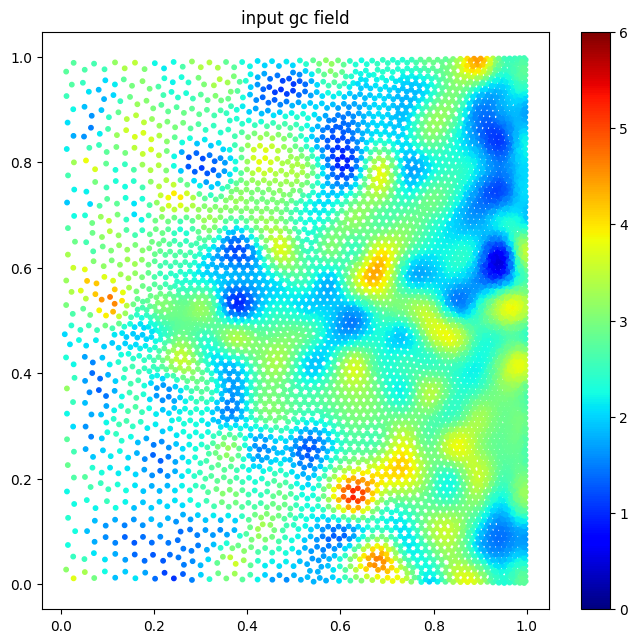

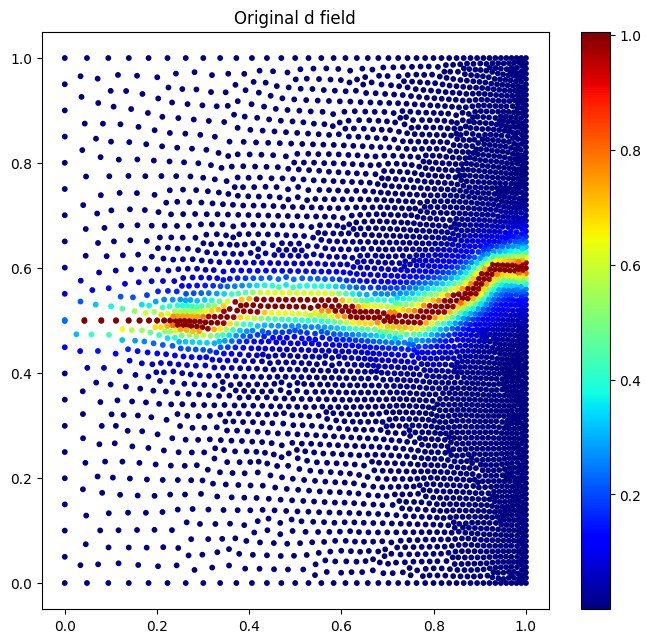

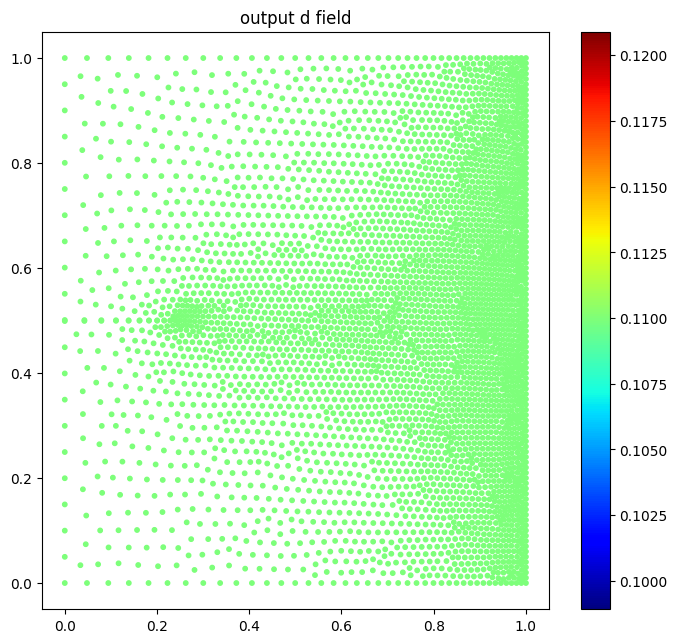

In [19]:
# visualize
# label
id1, id2 = 9,2  # 75 batchs 8 per batch
# i = id1*TEST_BATCH_SIZE + id2

# subplots
# gc

x_n, y_n = coordinates.iloc[:, 0], coordinates.iloc[:, 1]

plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
plt.scatter(x_n, y_n, c=data_list[id1][id2][:, 2], cmap='jet', s=10, vmin=0, vmax=6)
plt.colorbar()
plt.title('input gc field')


# original d
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
plt.scatter(damage_x, damage_y, c=damage_list[id1][id2][:,2], cmap='jet', s=10)
plt.colorbar()
plt.title('Original d field')

# d
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
plt.scatter(damage_x, damage_y, c=output_list[id1][id2], cmap='jet', s=10)
plt.colorbar()
plt.title('output d field')



# # subplots
# plt.subplot(1, 2, 2)
# plt.scatter(x_ver, y_ver, c=d_label_test_list[id1][id2], cmap='jet', s=10)
# plt.colorbar()
# plt.title('AE Recon d field')


# # predicted values
# plt.figure(figsize=(18, 7.5))
# plt.subplot(1, 2, 1)
# plt.scatter(x_ver, y_ver, c=d_hat_test_list[id1][id2], cmap='jet', s=10)
# plt.colorbar()
# plt.title('Predicted d field')

In [180]:
# clear cuda cache and memory
torch.cuda.empty_cache()

In [181]:
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Allocated: 6.9 GB
Cached:    7.1 GB


/home/jinyi12/miniconda3/envs/phasefield/lib/python3.8/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
